In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from glob import glob
import seaborn as sns
%matplotlib inline

In [3]:
import train_util
import util
%load_ext autoreload
%autoreload 2

from keras.models import load_model

/root/anaconda3/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
X_test, X_feat_test, _, _, _ = train_util.get_data(data_type='test', size=(128, 128, 3))


100%|██████████| 18000/18000 [00:52<00:00, 341.43it/s]


In [6]:
X_train, X_feat_train, Y_train, Y_no_sult, Y_salt_cls = train_util.get_data(data_type='train', size=(128, 128, 3))

100%|██████████| 3887/3887 [00:41<00:00, 94.04it/s]


In [7]:
model = load_model('./log/2018_0729_1817/best_weights.hdf5', custom_objects={
    'mean_iou': train_util.mean_iou, 
    'dice_p_bce':train_util.dice_p_bce, 
    'dice_coef':train_util.dice_coef,
    'true_positive_rate':train_util.true_positive_rate,
})

In [8]:
#since numpy array is Mutable, by ref
_, X_feat_test_norm = train_util.norm_X_feat(X_feat_train, X_feat_test)

In [9]:
X_feat_test_norm.std()

1.0125265

In [10]:
X_test.shape

(18000, 128, 128, 3)

In [11]:
preds_test = model.predict(X_test, verbose=1)

18000/18000 [==============================] - 25s 1ms/step


In [12]:

from sklearn.cross_validation import train_test_split
x_train, x_test, x_feat_train, x_feat_test, y_train, y_test, y_no_sult_train, y_no_sult_test = train_test_split(X_train, X_feat_train, Y_train, Y_no_sult, test_size=0.1, random_state=42)

In [13]:
x_feat_train, x_feat_test = train_util.norm_X_feat(x_feat_train, x_feat_test)
# preds_train_test = model.predict(([x_test ,x_feat_test]), verbose=1)
preds_train_test = model.predict(x_test , verbose=1)

389/389 [==============================] - 1s 2ms/step


### Make no sult masks

In [14]:
no_sult_classifier = load_model('./log/2018_0728_1659/best_weights.hdf5')

In [15]:
no_sult_preds = no_sult_classifier.predict(x_test, verbose=1)

389/389 [==============================] - 2s 4ms/step


In [16]:
no_sult_preds = no_sult_preds[:, 1]

In [17]:
preds_train_test_thresh = (preds_train_test > 0.5).astype(np.uint8)
preds_mean_sult = preds_train_test_thresh.mean(axis=-1).mean(axis=-1).mean(axis=-1)


In [18]:
preds_no_sult = pd.DataFrame({'preds_mean_sult': preds_mean_sult, 'no_sult':y_no_sult_test, 'no_sult_prob': no_sult_preds})

In [90]:
# tgt_index = preds_no_sult[(preds_no_sult['no_sult'] == 1) & (preds_no_sult['preds_mean_sult'] != 0)].index
tgt_index = preds_no_sult[(preds_no_sult['no_sult_prob'] > 0.5) & (preds_no_sult['preds_mean_sult'] != 0)].index
# tgt_index = preds_no_sult[(preds_no_sult['no_sult_prob'] < 0.5) & (preds_no_sult['preds_mean_sult'] == 0)].index

In [91]:
tgt_index

Int64Index([  2,  16,  41,  59,  60,  72,  76, 122, 178, 205, 209, 223, 239,
            253, 269, 272, 276, 282, 299, 300, 314, 339, 349, 367, 372, 373],
           dtype='int64')

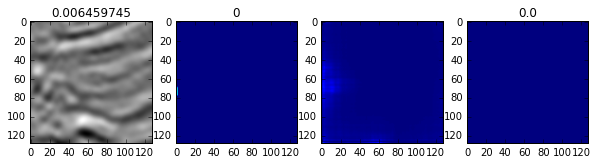

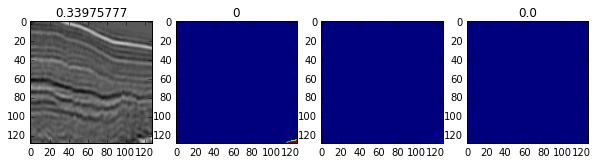

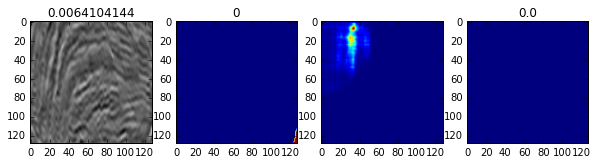

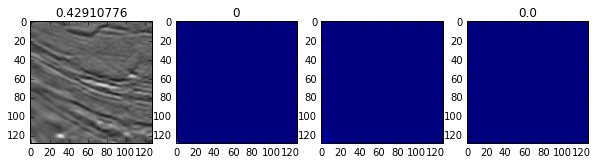

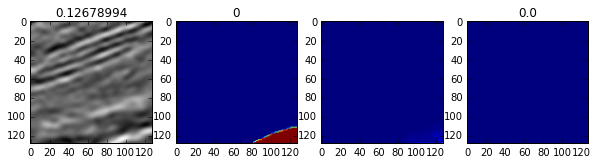

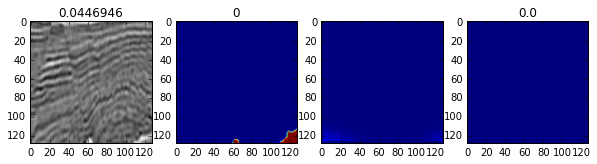

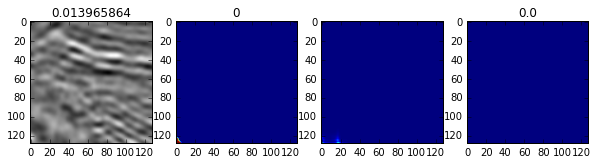

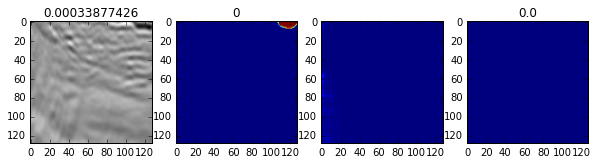

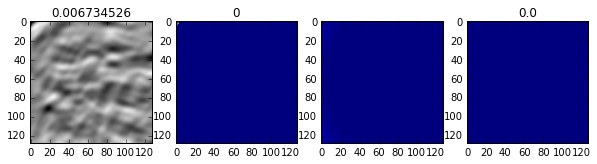

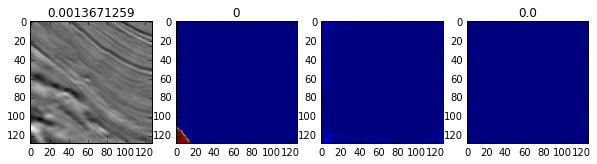

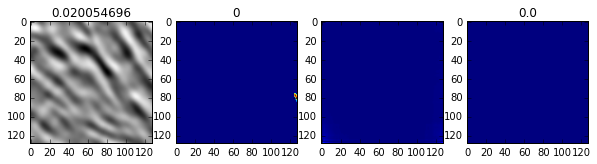

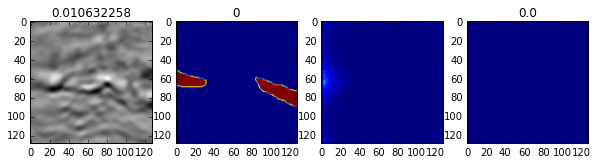

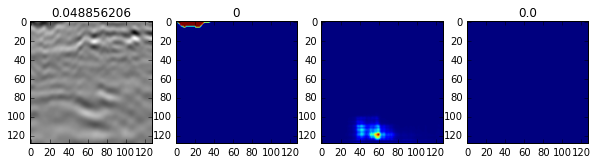

In [20]:
counter = 0
n = 4
for i in tgt_index:
    if counter % n == 0:
        plt.figure(figsize=(10, 5))
#         original
    original_im = x_test[i]
    plt.subplot(1, n, counter%n + 1)
    plt.title(no_sult_preds[i])
    plt.imshow(original_im)
    
#     mask
    mask = y_test[i]
    plt.subplot(1, n, counter%n + 2)
    plt.title(y_no_sult_test[i])
    plt.imshow(np.squeeze(mask))
    
#     prediction mask (original)
    pred_mask = preds_train_test[i]
    plt.subplot(1, n, counter%n + 3)
    plt.imshow(np.squeeze(pred_mask))
    
#     prediction mask (threshold)
    pred_mask_thresh  = preds_train_test_thresh[i]
    plt.subplot(1, n, counter%n + 4)
    plt.title(preds_mean_sult[i])
    plt.imshow(np.squeeze(pred_mask_thresh))
    
    counter += 4

In [21]:
tgt_index

Int64Index([9, 35, 103, 127, 128, 133, 175, 215, 305, 309, 347, 381, 382], dtype='int64')

In [22]:
# preds_no_sult[(preds_no_sult['no_sult'] == 1) & (preds_no_sult['preds_mean_sult'] != 0)]

In [23]:
# preds_no_sult[(preds_no_sult['no_sult'] == 0) & (preds_no_sult['preds_mean_sult'] == 0)]

In [24]:
# preds_no_sult.sort_values('preds_mean_sult')[preds_no_sult['preds_mean_sult'] != 0]

In [25]:
thresholds = np.linspace(0, 1, 50)
# ious = np.array([util.iou_metric_batch(y_test, np.int32(preds_train_test > threshold)) for threshold in tqdm(thresholds)])
ious = np.array([util.iou_metric_batch(y_test[tgt_index], np.int32(preds_train_test[tgt_index] > threshold)) for threshold in tqdm(thresholds)])

100%|██████████| 50/50 [00:01<00:00, 32.17it/s]


In [28]:
util.iou_metric_batch(y_test[:10], np.int32(preds_train_test[:10] > 0.5))

0.6399999999999999

In [251]:
tgt = 16
computed_iou= train_util.compute_iou(y_test[tgt], np.int32(preds_train_test[tgt] > 0.5))
print(computed_iou)
y_pred = np.int32(preds_train_test > 0.5)
iou = iou_coef(y_test, y_pred)
print(K.get_value(iou)[tgt])

0.0
2.2763487e-08


In [252]:
a = _

In [253]:
# a[0][0]

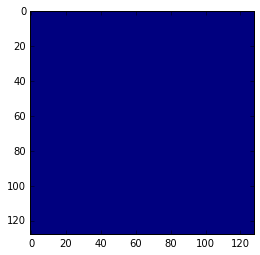

In [254]:
plt.imshow(np.squeeze(y_test[tgt]))

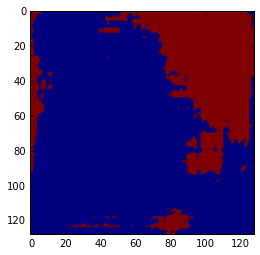

In [255]:
plt.imshow(np.squeeze(np.int32(preds_train_test[tgt] > 0.5)))

In [268]:
import keras.backend as K
def iou_coef(y_true, y_pred, smooth=0.0001):
    """
    IoU = (|X & Y|)/ (|X or Y|)
    """
    y_true = tf.to_int32(K.variable(y_true))
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1, 2, 3])
    union = K.sum(y_true,[1, 2, 3]) + K.sum(y_pred, [1, 2, 3]) - intersection
    return (intersection + smooth) / ( union + smooth)

In [269]:
preds_train_test_tensor = K.variable(preds_train_test)

In [270]:
import tensorflow as tf

test  = tf.to_int32(preds_train_test_tensor > 0.5)

In [271]:
y_pred

<tf.Variable 'Variable_47:0' shape=(389, 128, 128, 1) dtype=float32_ref>

In [272]:
y_pred = K.variable(np.int32(preds_train_test > 0.5))
y_pred_tg = tf.to_int32(K.variable(preds_train_test) > 0.5)

iou = iou_coef(y_test, y_pred)
K.get_value(iou)

ValueError: Incompatible type conversion requested to type 'int32' for variable of type 'float32_ref'

In [273]:
iou = iou_coef(y_test, y_pred_tg)
K.get_value(iou)

TypeError: unsupported operand type(s) for +: 'Tensor' and 'float'

In [ ]:
preds_train_test

array([1.00000000e+00, 9.69132066e-01, 2.17390834e-06, 9.51375484e-01,
       1.00000000e+00, 3.80413413e-01, 9.22169447e-01, 9.40366328e-01,
       7.56885707e-01, 8.53406345e-06, 1.00000000e+00, 9.11805511e-01,
       1.00000000e+00, 1.00000000e+00, 7.83385992e-01, 5.01279235e-01,
       2.27634871e-08, 1.00000000e+00, 9.55428362e-01, 1.00000000e+00,
       9.46571946e-01, 8.96194458e-01, 1.00000000e+00, 9.97553527e-01,
       1.00000000e+00, 7.53845692e-01, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 9.91572320e-01, 7.15186372e-02, 8.56747150e-01,
       9.03015494e-01, 1.00000000e+00, 9.87760484e-01, 3.66694098e-06,
       1.00000000e+00, 1.00000000e+00, 7.90848136e-01, 6.11693382e-01,
       3.14738159e-03, 1.25234809e-08, 1.00000000e+00, 9.34022129e-01,
       1.00000000e+00, 9.32591140e-01, 1.00000000e+00, 9.03483450e-01,
       8.97731721e-01, 9.93821919e-01, 9.72304821e-01, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
      

In [187]:
y_true_t = K.variable(y_test)
y_pred_t = K.variable(y_pred)
sum = K.sum(y_test, [1,2, 3])

In [189]:
intersection = K.sum(K.abs(y_true_t * y_pred_t), axis=[1, 2, 3])

In [190]:
K.get_value(intersection).shape

(389,)

In [174]:
y_test.shape

(389, 128, 128, 1)

In [65]:
threshold_best_index = np.argmax(ious[9:-10]) + 9
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

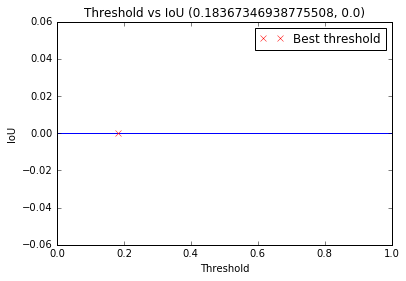

In [41]:
plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend(loc='best')

In [42]:
threshold_best

0.18367346938775508

In [43]:
preds_test_t = (preds_test > 0.5).astype(np.uint8)

### Make no sult mask

In [44]:
preds_no_sult_test = no_sult_classifier.predict(X_test, verbose=1)

18000/18000 [==============================] - 51s 3ms/step


In [45]:
# prediction has two values one is prob for sult and the other is for no sult
preds_no_sult_test = preds_no_sult_test[:, 1]

In [46]:
size = (128, 128, 1)
for i, p in enumerate(preds_test_t):
    mean = p.mean()
    no_sult_prob = preds_no_sult_test[i]
    if (mean > 0) and (no_sult_prob > 0.6) :
        preds_test_t[i] = np.zeros(size)
    if (mean == 0) and (no_sult_prob < 0.5):
        preds_test_t[i] = (preds_test[i] > 0.2).astype(np.uint8)

In [47]:
# preds_train_test_thresh = (preds_train_test > threshold_best).astype(np.uint8)
# preds_mean_sult = preds_train_test_thresh.mean(axis=-1).mean(axis=-1).mean(axis=-1)
# preds_no_sult = pd.DataFrame({'preds_mean_sult': preds_mean_sult, 'no_sult':y_no_sult_test})

In [48]:
# preds_no_sult[(preds_no_sult['no_sult'] == 1) & (preds_no_sult['preds_mean_sult'] != 0)]

In [49]:
preds_test_t_mean = preds_test_t.mean(axis=-1).mean(axis=-1).mean(axis=-1)
# # no_sult_thresh = 0.0053

In [50]:
mean_df = pd.DataFrame({'mean': preds_test_t_mean, 'no_salt_prob':preds_no_sult_test})

In [51]:
mean_df[(mean_df['no_salt_prob'] > 0.5) & (mean_df['mean'] != 0)]

,mean,no_salt_prob
1,0.126709,0.510622
153,0.603760,0.575246
260,0.195251,0.576696
283,0.064758,0.553460
346,0.069092,0.511504
583,0.008545,0.586446
590,0.028198,0.539489
637,1.000000,0.567916
791,0.013123,0.598245
956,0.861877,0.543957


In [52]:
no_sult_index = int(0.38*18000)
# mean_df.sort_values('mean')[:no_sult_index]

In [53]:
# mean_df[mean_df['mean'] == 0]

In [54]:
# size = (128, 128, 1)
# for i, p in enumerate(preds_test_t):
#     mean = p.mean()
#     if mean < 0.0053:
#         preds_test_t[i] = np.zeros(size)

In [55]:
preds_test_t.shape

(18000, 128, 128, 1)

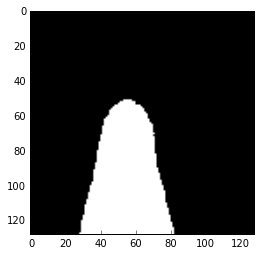

In [56]:
plt.gray()
plt.imshow(np.squeeze(preds_test_t[5]))

In [57]:
preds_test_resize = []
for pred_mask in preds_test_t:
    resized = cv2.resize(pred_mask, (101, 101))
    preds_test_resize.append(resized)

In [58]:
preds_test_resize[0].shape# preds_no_sult[(preds_no_sult['no_sult'] == 1) & (preds_no_sult['preds_mean_sult'] != 0)]

(101, 101)

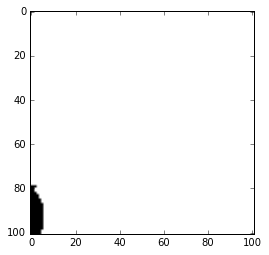

In [59]:
plt.imshow(preds_test_resize[0])

## Submission

In [60]:
test_ids = [p.split('/')[-1].split('.')[0] for p in glob('./data/test/images/*')]

In [61]:
len(test_ids)

18000

In [62]:
from tqdm import tqdm
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

pred_dict = {fn:RLenc(np.round(preds_test_resize[i])) for i,fn in tqdm(enumerate(test_ids), total=len(test_ids))}

100%|██████████| 18000/18000 [05:07<00:00, 58.48it/s]


In [64]:
sub  = pd.DataFrame.from_dict(pred_dict, orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('./submission/submission8.csv')

In [83]:
len(preds_test_resize)

18000

## CRF

KeyError: 'the label [10] is not in the [index]'

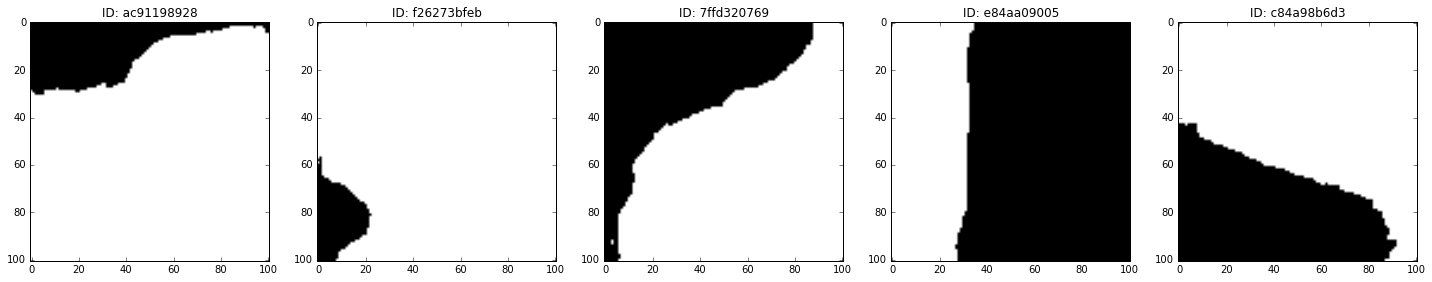

In [66]:
import pydensecrf.densecrf as dcrf
from skimage.io import imread, imsave
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral
from skimage.color import gray2rgb
from skimage.color import rgb2gray
def rle_decode(mask_rle, shape=(101, 101)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)





"""
reading and decoding the submission 

"""
df = pd.read_csv('./submission/submission8.csv')[:10]
i = 0
j = 0
plt.figure(figsize=(30,15))
plt.subplots_adjust(bottom=0.2, top=0.8, hspace=0.2)  #adjust this to change vertical and horiz. spacings..
# Visualizing the predicted outputs
while True:
    if str(df.loc[i,'rle_mask'])!=str(np.nan):        
        decoded_mask = rle_decode(df.loc[i,'rle_mask'])
        plt.subplot(1,6,j+1)
        plt.imshow(decoded_mask)
        plt.title('ID: '+df.loc[i,'id'])
        j = j + 1
        if j>5:
            break
    i = i + 1

In [67]:
df = pd.read_csv('./submission/submission8.csv')
test_path = './data/test/images/'
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


"""
Function which returns the labelled image after applying CRF

"""
#Original_image = Image which has to labelled
#Mask image = Which has been labelled by some technique..
def crf(original_image, mask_img):
    
    # Converting annotated image to RGB if it is Gray scale
    if(len(mask_img.shape)<3):
        mask_img = gray2rgb(mask_img)

#     #Converting the annotations RGB color to single 32 bit integer
    annotated_label = mask_img[:,:,0] + (mask_img[:,:,1]<<8) + (mask_img[:,:,2]<<16)
    
#     # Convert the 32bit integer color to 0,1, 2, ... labels.
    colors, labels = np.unique(annotated_label, return_inverse=True)

    n_labels = 2
    
    #Setting up the CRF model
    d = dcrf.DenseCRF2D(original_image.shape[1], original_image.shape[0], n_labels)

    # get unary potentials (neg log probability)
    U = unary_from_labels(labels, n_labels, gt_prob=0.7, zero_unsure=False)
    d.setUnaryEnergy(U)

    # This adds the color-independent term, features are the locations only.
    d.addPairwiseGaussian(sxy=(3, 3), compat=3, kernel=dcrf.DIAG_KERNEL,
                      normalization=dcrf.NORMALIZE_SYMMETRIC)
        
    #Run Inference for 10 steps 
    Q = d.inference(10)

    # Find out the most probable class for each pixel.
    MAP = np.argmax(Q, axis=0)

    return MAP.reshape((original_image.shape[0],original_image.shape[1]))




"""
Applying CRF on the predicted mask 

"""
for i in tqdm(range(df.shape[0])):
    if str(df.loc[i,'rle_mask'])!=str(np.nan):        
        decoded_mask = rle_decode(df.loc[i,'rle_mask'])        
        orig_img = imread(test_path+df.loc[i,'id']+'.png')        
        crf_output = crf(orig_img,decoded_mask)
        df.loc[i,'rle_mask'] = rle_encode(crf_output)

100%|██████████| 18000/18000 [02:54<00:00, 103.11it/s]


In [69]:
df.to_csv('./submission/submission8_crf.csv',index=False)

In [30]:
sub4 = pd.read_csv('submission4.csv')


In [32]:
sub4.head()

,id,rle_mask
0,4fd8abbdb5,NaN
1,0d10332602,NaN
2,8299b97f38,NaN
3,d028ae45d9,1 90 102 89 203 88 304 88 405 88 506 88 607 88...
4,0aa2cfd2e2,26 76 127 76 228 76 329 76 431 75 530 77 631 7...


In [33]:
sub4_crf = pd.read_csv('submission4_crf.csv')

In [35]:
sub4_crf[sub4_crf['id'] == 'd028ae45d9']

,id,rle_mask
11647,d028ae45d9,1 92 102 92 203 91 304 91 405 90 506 89 607 88...
